In [1]:
import datetime
import os
import sys
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from tqdm import tqdm

# Hack for module imports
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.loaders import FlatsDatasetLoader
from internal_modules.inference import infer, evaluate, predict_image
from internal_modules.metrics import Metrics
from internal_modules import plots
from internal_modules.utils import torch_utils

## Prepare the constants

#### Set device and hyperparameters

In [2]:
device = torch_utils.select_device()
image_size = 256
batch_size = 32
learning_rate = 0.00001
momentum = 0.9
epochs = 30
experiment_name = 'VGG16-Jupyter'

Will operate on device mps
Torch version: 1.13.1


#### Set the paths

In [3]:
dataset_path = os.path.join(module_path, "data/images/houzz_subset2/")
models_folder_path = os.path.abspath(os.path.join(module_path, "experiments/models"))

## Prepare data

In [4]:
# Set path to the dataset. The module_path is the root path of the project.

# Load the dataset
data_loader = FlatsDatasetLoader(
    images_dir=dataset_path,
    resize_to=image_size,
    device=device,
    batch_size=batch_size,
)

In [5]:
full_dataset = data_loader.load(verbose=True)
train_loader = data_loader.get_train_loader()
test_loader = data_loader.get_test_loader()
classes_count = data_loader.get_classes_count()
classes = list(data_loader.get_label_names().values())

Workers count: 5
Loading dataset from files...
Done.


In [6]:
print("Dataset description")
print(data_loader)

Dataset description
{
  "FullDatasetCount": 1600,
  "TrainDatasetCount": 1280,
  "TestDatasetCount": 320,
  "ClassesCount": 8,
  "LabelNames": {
    "0": "ArtDeco",
    "1": "Classic",
    "2": "Glamour",
    "3": "Industrial",
    "4": "Modern",
    "5": "Rustic",
    "6": "Scandinavian",
    "7": "Vintage"
  }
}


#### Dataset distribution

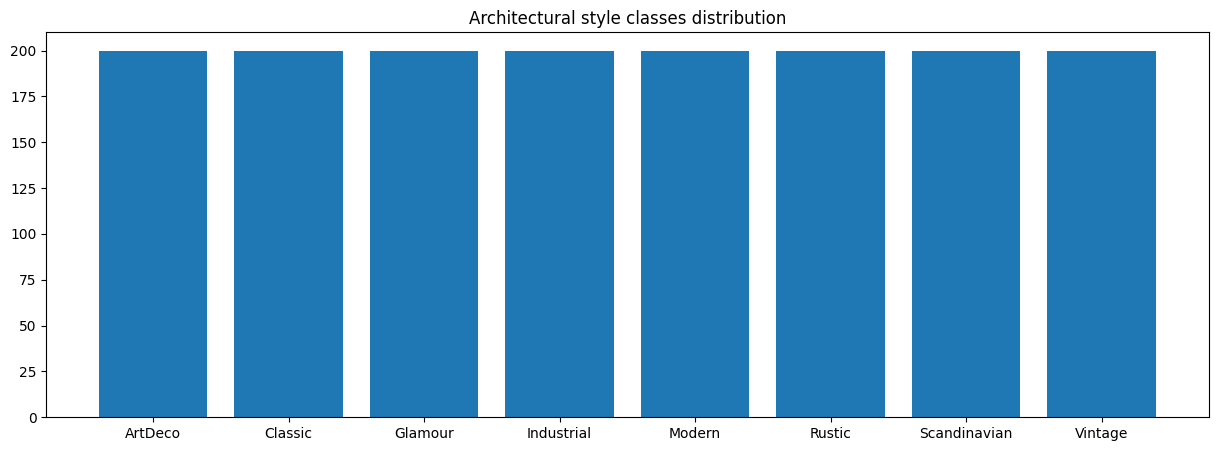

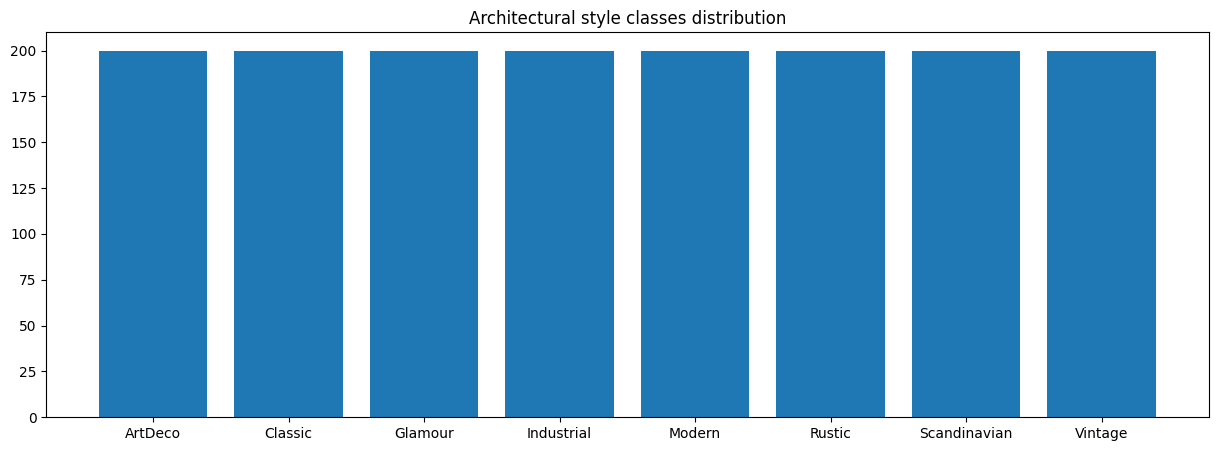

In [7]:
plots.plot_data_distribution(full_dataset, classes)

## Define functions for experiment

#### Functions for saving models

In [8]:
import copy

# Saves model to given path in .pt format
def save_model(model, model_path):
    model_path = model_path.replace(".pt", "-standard.pt")
    model_directory = os.path.abspath(
        os.path.join(os.path.abspath(model_path), os.pardir)
    )
    try:
        os.mkdir(model_directory)
    except FileExistsError:
        pass
    torch.save(model, model_path)
    print(f"Model saved in {model_path}")

# Saves torchscript model to given path in .pt format
def save_model_torchscript(model, model_path):
    model_path = model_path.replace(".pt", "-torchscript.pt")
    model_directory = os.path.abspath(
        os.path.join(os.path.abspath(model_path), os.pardir)
    )
    try:
        os.mkdir(model_directory)
    except FileExistsError:
        pass
    model_cp = copy.deepcopy(model)
    model_cp.to("cpu")
    model_scripted = torch.jit.script(model_cp)
    model_scripted.save(model_path)
    print(f"Model saved in {model_path}")

#### Function for model training

In [9]:
def train(
    model: nn.Module,
    flats_dataset_loader: FlatsDatasetLoader,
    optimizer_fn: Optimizer,
    loss_fn,
    device: str,
    epochs: int,
    use_mlflow: bool = False,
) -> tuple[Metrics, Metrics]:
    train_data = flats_dataset_loader.get_train_loader()
    test_data = flats_dataset_loader.get_test_loader()
    test_metrics = Metrics(use_mlflow=use_mlflow, set_name="test")
    train_metrics = Metrics(use_mlflow=use_mlflow, set_name="train")

    model = model.to(device)
    model.train()
    epoch = 0
    for _ in tqdm(range(epochs), total=epochs):
        epoch += 1
        print(f"Starting epoch: {epoch}...")
        train_outs, train_losses = np.array([]), []
        labels = np.array([])

        for batch_idx, data in enumerate(train_data):
            optimizer_fn.zero_grad()
            output, loss = infer(data, model, loss_fn, device)
            labels = np.concatenate((labels, data[1].data.numpy()))
            train_outs = np.concatenate(
                (
                    train_outs,
                    torch.nn.functional.softmax(output, dim=1)
                    .cpu()
                    .data.numpy()
                    .argmax(axis=1),
                )
            )
            loss.backward()
            train_losses.append(loss.item())
            optimizer_fn.step()

            if batch_idx % 50 == 0:
                print(
                    f"Training set ["
                    f"{batch_idx * len(data[0])}/{len(train_data.dataset)} "
                    f"({100.0 * batch_idx / len(train_data):.0f}%)] "
                    f"Loss: {loss.item():.6f}"
                )
        print(f"Training finished in epoch: {epoch}...")
        train_metrics.add_new(train_outs, labels, train_losses)
        print("Evaluating model...")
        test_trues, test_predictions, test_losses = evaluate(
            model, test_data, loss_fn, device
        )
        print("Evaluation finished.")
        test_metrics.add_new(test_predictions, test_trues, test_losses)
        print(f"Metrics after epoch: {epoch}: ", end="")
        print(test_metrics)

    return test_metrics, train_metrics

#### Function for conducting the whole experiment

In [10]:
def conduct_experiment(
    title,
    model,
    n_epochs,
    optimizer,
    flats_dataset_loader: FlatsDatasetLoader,
    device: str,
    criterion=nn.CrossEntropyLoss(),
    use_mlflow=False,
    register_model=False,
):
    # Train model
    start = time.time()
    model = model.to(device)
    test_metrics, train_metrics = train(
        model, flats_dataset_loader, optimizer, criterion, device, n_epochs, use_mlflow)
    end = time.time()
    print(f"Training finished in {end - start} seconds")

    local_model_name = f"{datetime.datetime.now().strftime('%y-%b-%d-%H-%M')}.pt"
    model_path = os.path.join(
        models_folder_path,
        title,
        local_model_name,
    )
    # Save models
    save_model(model, model_path)
    save_model_torchscript(model, model_path)

    # Evaluate model and plot results
    combined_plots = plots.plot_metrics(
        title,
        test_metrics,
        train_metrics,
        n_epochs,
        time=end - start,
        device=device)
    test_loader = flats_dataset_loader.get_test_loader()
    print("Evaluating model on test dataset...")
    _, predictions, _ = evaluate(model, test_loader, criterion, device)
    misclassified_figure = plots.show_misclassified(
        test_loader.dataset, predictions, flats_dataset_loader.get_label_names())

    return test_metrics, train_metrics

## Train the model

#### Load model with pretrained weights and set optimizer

In [11]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#### Prepare model for transfer learning

In [12]:
for param in model.features.parameters():
    param.require_grad = False

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, classes_count)])
model.classifier = nn.Sequential(*features)

#### Run model training

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch: 1...
Training set [0/1280 (0%)] Loss: 2.260746
Training finished in epoch: 1...
Evaluating model...


  3%|▎         | 1/30 [02:09<1:02:49, 129.98s/it]

Evaluation finished.
Metrics after epoch: 1: {
  "loss": 2.1109039306640627,
  "acc": 0.125,
  "precision": 0.07250928748870822,
  "recall": 0.125,
  "f1": 0.09046714332242504
}
Starting epoch: 2...
Training set [0/1280 (0%)] Loss: 2.049316
Training finished in epoch: 2...
Evaluating model...


  7%|▋         | 2/30 [04:36<1:05:17, 139.92s/it]

Evaluation finished.
Metrics after epoch: 2: {
  "loss": 2.1077957153320312,
  "acc": 0.125,
  "precision": 0.07483164983164983,
  "recall": 0.125,
  "f1": 0.09218452380952383
}
Starting epoch: 3...
Training set [0/1280 (0%)] Loss: 2.129449
Training finished in epoch: 3...
Evaluating model...


 10%|█         | 3/30 [06:52<1:02:07, 138.06s/it]

Evaluation finished.
Metrics after epoch: 3: {
  "loss": 2.105243110656738,
  "acc": 0.13125,
  "precision": 0.08523555252024431,
  "recall": 0.13125,
  "f1": 0.10083868026893308
}
Starting epoch: 4...
Training set [0/1280 (0%)] Loss: 2.130303
Training finished in epoch: 4...
Evaluating model...


 13%|█▎        | 4/30 [09:04<58:46, 135.62s/it]  

Evaluation finished.
Metrics after epoch: 4: {
  "loss": 2.102673125267029,
  "acc": 0.13125,
  "precision": 0.08560694864592336,
  "recall": 0.13125,
  "f1": 0.10140418397206422
}
Starting epoch: 5...
Training set [0/1280 (0%)] Loss: 2.107152
Training finished in epoch: 5...
Evaluating model...


 17%|█▋        | 5/30 [11:15<55:52, 134.09s/it]

Evaluation finished.
Metrics after epoch: 5: {
  "loss": 2.1002145051956176,
  "acc": 0.13125,
  "precision": 0.08669430730700152,
  "recall": 0.13125,
  "f1": 0.10223542654822179
}
Starting epoch: 6...
Training set [0/1280 (0%)] Loss: 2.139054
Training finished in epoch: 6...
Evaluating model...


 20%|██        | 6/30 [13:40<55:06, 137.77s/it]

Evaluation finished.
Metrics after epoch: 6: {
  "loss": 2.097822332382202,
  "acc": 0.13125,
  "precision": 0.0870644292591645,
  "recall": 0.13125,
  "f1": 0.10246971718601157
}
Starting epoch: 7...
Training set [0/1280 (0%)] Loss: 2.099804
Training finished in epoch: 7...
Evaluating model...


 23%|██▎       | 7/30 [16:00<53:00, 138.30s/it]

Evaluation finished.
Metrics after epoch: 7: {
  "loss": 2.0955121994018553,
  "acc": 0.134375,
  "precision": 0.09479242979242979,
  "recall": 0.134375,
  "f1": 0.107645432789979
}
Starting epoch: 8...
Training set [0/1280 (0%)] Loss: 2.051087
Training finished in epoch: 8...
Evaluating model...


 27%|██▋       | 8/30 [18:08<49:30, 135.03s/it]

Evaluation finished.
Metrics after epoch: 8: {
  "loss": 2.0930495977401735,
  "acc": 0.140625,
  "precision": 0.10327279202279202,
  "recall": 0.140625,
  "f1": 0.11478326067815751
}
Starting epoch: 9...
Training set [0/1280 (0%)] Loss: 2.106454
Training finished in epoch: 9...
Evaluating model...


 30%|███       | 9/30 [20:26<47:39, 136.17s/it]

Evaluation finished.
Metrics after epoch: 9: {
  "loss": 2.0908886909484865,
  "acc": 0.1375,
  "precision": 0.10093900932111581,
  "recall": 0.1375,
  "f1": 0.11301730437343811
}
Starting epoch: 10...
Training set [0/1280 (0%)] Loss: 2.038371
Training finished in epoch: 10...
Evaluating model...


 33%|███▎      | 10/30 [22:51<46:13, 138.66s/it]

Evaluation finished.
Metrics after epoch: 10: {
  "loss": 2.0886191606521605,
  "acc": 0.134375,
  "precision": 0.09581692850528467,
  "recall": 0.134375,
  "f1": 0.10903826318684962
}
Starting epoch: 11...
Training set [0/1280 (0%)] Loss: 2.109520
Training finished in epoch: 11...
Evaluating model...


 37%|███▋      | 11/30 [25:18<44:42, 141.18s/it]

Evaluation finished.
Metrics after epoch: 11: {
  "loss": 2.08616464138031,
  "acc": 0.15,
  "precision": 0.11607353045596555,
  "recall": 0.15,
  "f1": 0.12613383703179054
}
Starting epoch: 12...
Training set [0/1280 (0%)] Loss: 2.059378
Training finished in epoch: 12...
Evaluating model...


 40%|████      | 12/30 [27:43<42:46, 142.59s/it]

Evaluation finished.
Metrics after epoch: 12: {
  "loss": 2.083881640434265,
  "acc": 0.15625,
  "precision": 0.12470016706621885,
  "recall": 0.15625,
  "f1": 0.13294773563319986
}
Starting epoch: 13...
Training set [0/1280 (0%)] Loss: 2.011415
Training finished in epoch: 13...
Evaluating model...


 43%|████▎     | 13/30 [30:12<40:57, 144.54s/it]

Evaluation finished.
Metrics after epoch: 13: {
  "loss": 2.0815821647644044,
  "acc": 0.159375,
  "precision": 0.1443155372978892,
  "recall": 0.159375,
  "f1": 0.13650689973225902
}
Starting epoch: 14...
Training set [0/1280 (0%)] Loss: 2.036789
Training finished in epoch: 14...
Evaluating model...


 47%|████▋     | 14/30 [32:39<38:40, 145.01s/it]

Evaluation finished.
Metrics after epoch: 14: {
  "loss": 2.0793556451797484,
  "acc": 0.159375,
  "precision": 0.15762240654849613,
  "recall": 0.159375,
  "f1": 0.13949927251472477
}
Starting epoch: 15...
Training set [0/1280 (0%)] Loss: 2.039996
Training finished in epoch: 15...
Evaluating model...


 50%|█████     | 15/30 [34:59<35:53, 143.55s/it]

Evaluation finished.
Metrics after epoch: 15: {
  "loss": 2.0769449949264525,
  "acc": 0.16875,
  "precision": 0.16057718494178258,
  "recall": 0.16875,
  "f1": 0.14846653755482622
}
Starting epoch: 16...
Training set [0/1280 (0%)] Loss: 2.026788
Training finished in epoch: 16...
Evaluating model...


 53%|█████▎    | 16/30 [37:13<32:51, 140.85s/it]

Evaluation finished.
Metrics after epoch: 16: {
  "loss": 2.0746200561523436,
  "acc": 0.16875,
  "precision": 0.15992359192226216,
  "recall": 0.16875,
  "f1": 0.1483155712348229
}
Starting epoch: 17...
Training set [0/1280 (0%)] Loss: 2.107353
Training finished in epoch: 17...
Evaluating model...


 57%|█████▋    | 17/30 [39:39<30:49, 142.25s/it]

Evaluation finished.
Metrics after epoch: 17: {
  "loss": 2.072336292266846,
  "acc": 0.16875,
  "precision": 0.15965878347782475,
  "recall": 0.16875,
  "f1": 0.14815067013953281
}
Starting epoch: 18...
Training set [0/1280 (0%)] Loss: 2.025344
Training finished in epoch: 18...
Evaluating model...


 60%|██████    | 18/30 [42:48<31:14, 156.22s/it]

Evaluation finished.
Metrics after epoch: 18: {
  "loss": 2.069984245300293,
  "acc": 0.171875,
  "precision": 0.16093849253308018,
  "recall": 0.171875,
  "f1": 0.15282935609448234
}
Starting epoch: 19...
Training set [0/1280 (0%)] Loss: 1.980627
Training finished in epoch: 19...
Evaluating model...


 63%|██████▎   | 19/30 [50:06<44:09, 240.89s/it]

Evaluation finished.
Metrics after epoch: 19: {
  "loss": 2.0674452781677246,
  "acc": 0.184375,
  "precision": 0.17170493246232937,
  "recall": 0.184375,
  "f1": 0.16361608852973397
}
Starting epoch: 20...
Training set [0/1280 (0%)] Loss: 2.029558
Training finished in epoch: 20...
Evaluating model...


 67%|██████▋   | 20/30 [54:08<40:14, 241.41s/it]

Evaluation finished.
Metrics after epoch: 20: {
  "loss": 2.065069150924683,
  "acc": 0.184375,
  "precision": 0.1717459762134058,
  "recall": 0.184375,
  "f1": 0.16415710365017708
}
Starting epoch: 21...
Training set [0/1280 (0%)] Loss: 2.105577
Training finished in epoch: 21...
Evaluating model...


 70%|███████   | 21/30 [1:23:52<1:45:40, 704.45s/it]

Evaluation finished.
Metrics after epoch: 21: {
  "loss": 2.0627211809158323,
  "acc": 0.184375,
  "precision": 0.17197926651892487,
  "recall": 0.184375,
  "f1": 0.16447826165935797
}
Starting epoch: 22...
Training set [0/1280 (0%)] Loss: 1.989876
Training finished in epoch: 22...
Evaluating model...


 73%|███████▎  | 22/30 [1:26:04<1:10:59, 532.43s/it]

Evaluation finished.
Metrics after epoch: 22: {
  "loss": 2.0600975513458253,
  "acc": 0.184375,
  "precision": 0.17059983037088422,
  "recall": 0.184375,
  "f1": 0.16500691578101373
}
Starting epoch: 23...
Training set [0/1280 (0%)] Loss: 2.035971
Training finished in epoch: 23...
Evaluating model...


 77%|███████▋  | 23/30 [4:23:28<6:56:07, 3566.72s/it]

Evaluation finished.
Metrics after epoch: 23: {
  "loss": 2.057510781288147,
  "acc": 0.190625,
  "precision": 0.17477229099899919,
  "recall": 0.190625,
  "f1": 0.1694674387517637
}
Starting epoch: 24...
Training set [0/1280 (0%)] Loss: 1.971180
Training finished in epoch: 24...
Evaluating model...


 80%|████████  | 24/30 [6:30:34<7:58:29, 4784.90s/it]

Evaluation finished.
Metrics after epoch: 24: {
  "loss": 2.05478036403656,
  "acc": 0.196875,
  "precision": 0.1812336785170689,
  "recall": 0.196875,
  "f1": 0.1759976570229603
}
Starting epoch: 25...
Training set [0/1280 (0%)] Loss: 1.952590
Training finished in epoch: 25...
Evaluating model...


 83%|████████▎ | 25/30 [7:18:11<5:50:32, 4206.45s/it]

Evaluation finished.
Metrics after epoch: 25: {
  "loss": 2.0518927812576293,
  "acc": 0.203125,
  "precision": 0.18504888800946923,
  "recall": 0.203125,
  "f1": 0.18220352221534833
}
Starting epoch: 26...
Training set [0/1280 (0%)] Loss: 2.030868
Training finished in epoch: 26...
Evaluating model...


 87%|████████▋ | 26/30 [8:25:16<4:36:48, 4152.02s/it]

Evaluation finished.
Metrics after epoch: 26: {
  "loss": 2.0492471933364866,
  "acc": 0.2,
  "precision": 0.1780948379413203,
  "recall": 0.2,
  "f1": 0.17919298903704822
}
Starting epoch: 27...
Training set [0/1280 (0%)] Loss: 1.909281
Training finished in epoch: 27...
Evaluating model...


 90%|█████████ | 27/30 [9:14:34<3:09:41, 3793.75s/it]

Evaluation finished.
Metrics after epoch: 27: {
  "loss": 2.046295630931854,
  "acc": 0.20625,
  "precision": 0.18573647608109178,
  "recall": 0.20625,
  "f1": 0.1861765409222406
}
Starting epoch: 28...
Training set [0/1280 (0%)] Loss: 2.013224
Training finished in epoch: 28...
Evaluating model...


 93%|█████████▎| 28/30 [9:16:28<1:29:39, 2689.81s/it]

Evaluation finished.
Metrics after epoch: 28: {
  "loss": 2.043212962150574,
  "acc": 0.20625,
  "precision": 0.18561124176155466,
  "recall": 0.20625,
  "f1": 0.18569888222330272
}
Starting epoch: 29...
Training set [0/1280 (0%)] Loss: 1.981242
Training finished in epoch: 29...
Evaluating model...


 97%|█████████▋| 29/30 [9:18:23<31:57, 1917.30s/it]  

Evaluation finished.
Metrics after epoch: 29: {
  "loss": 2.0401667237281798,
  "acc": 0.20625,
  "precision": 0.18526007476022444,
  "recall": 0.20625,
  "f1": 0.18547055068917953
}
Starting epoch: 30...
Training set [0/1280 (0%)] Loss: 2.000378
Training finished in epoch: 30...
Evaluating model...


100%|██████████| 30/30 [9:20:18<00:00, 1120.60s/it]

Evaluation finished.
Metrics after epoch: 30: {
  "loss": 2.037176084518433,
  "acc": 0.20625,
  "precision": 0.18342703990075399,
  "recall": 0.20625,
  "f1": 0.1866023006262965
}
Training finished in 33618.18482398987 seconds


Model saved in /Users/adamwojdyla/Documents/Studia/Magisterskie/AITECH_TEMPLATE/AiTechTemplate/experiments/models/VGG16-Jupyter/23-Sep-19-08-59-standard.pt
Model saved in /Users/adamwojdyla/Documents/Studia/Magisterskie/AITECH_TEMPLATE/AiTechTemplate/experiments/models/VGG16-Jupyter/23-Sep-19-08-59-torchscript.pt
Evaluating model on test dataset...


/Users/adamwojdyla/Documents/Studia/Magisterskie/AITECH_TEMPLATE/AiTechTemplate/internal_modules/plots.py:78: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axis, labels=["test", "train"], loc="lower center")


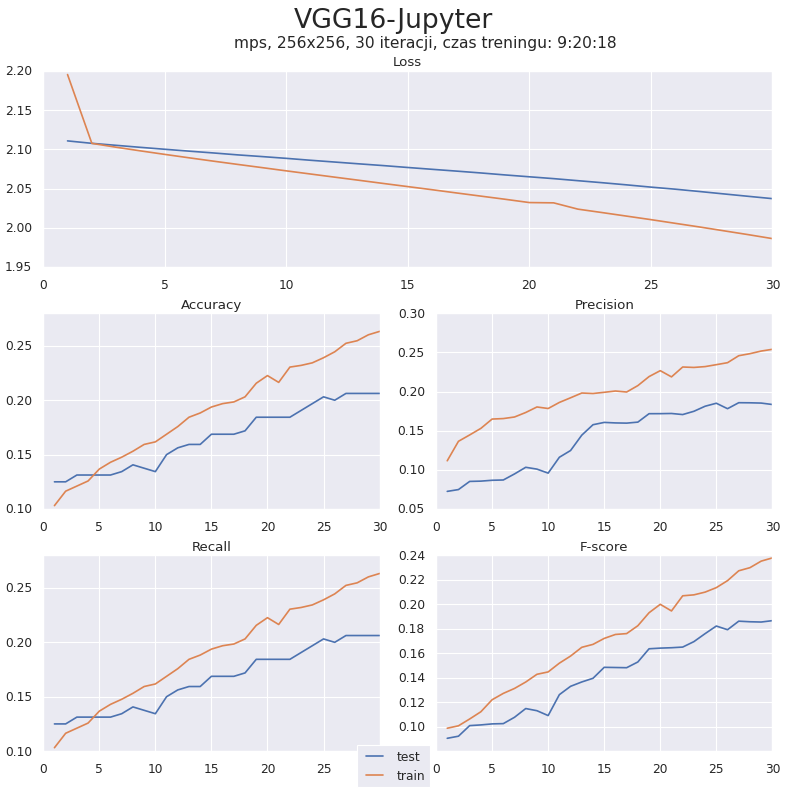

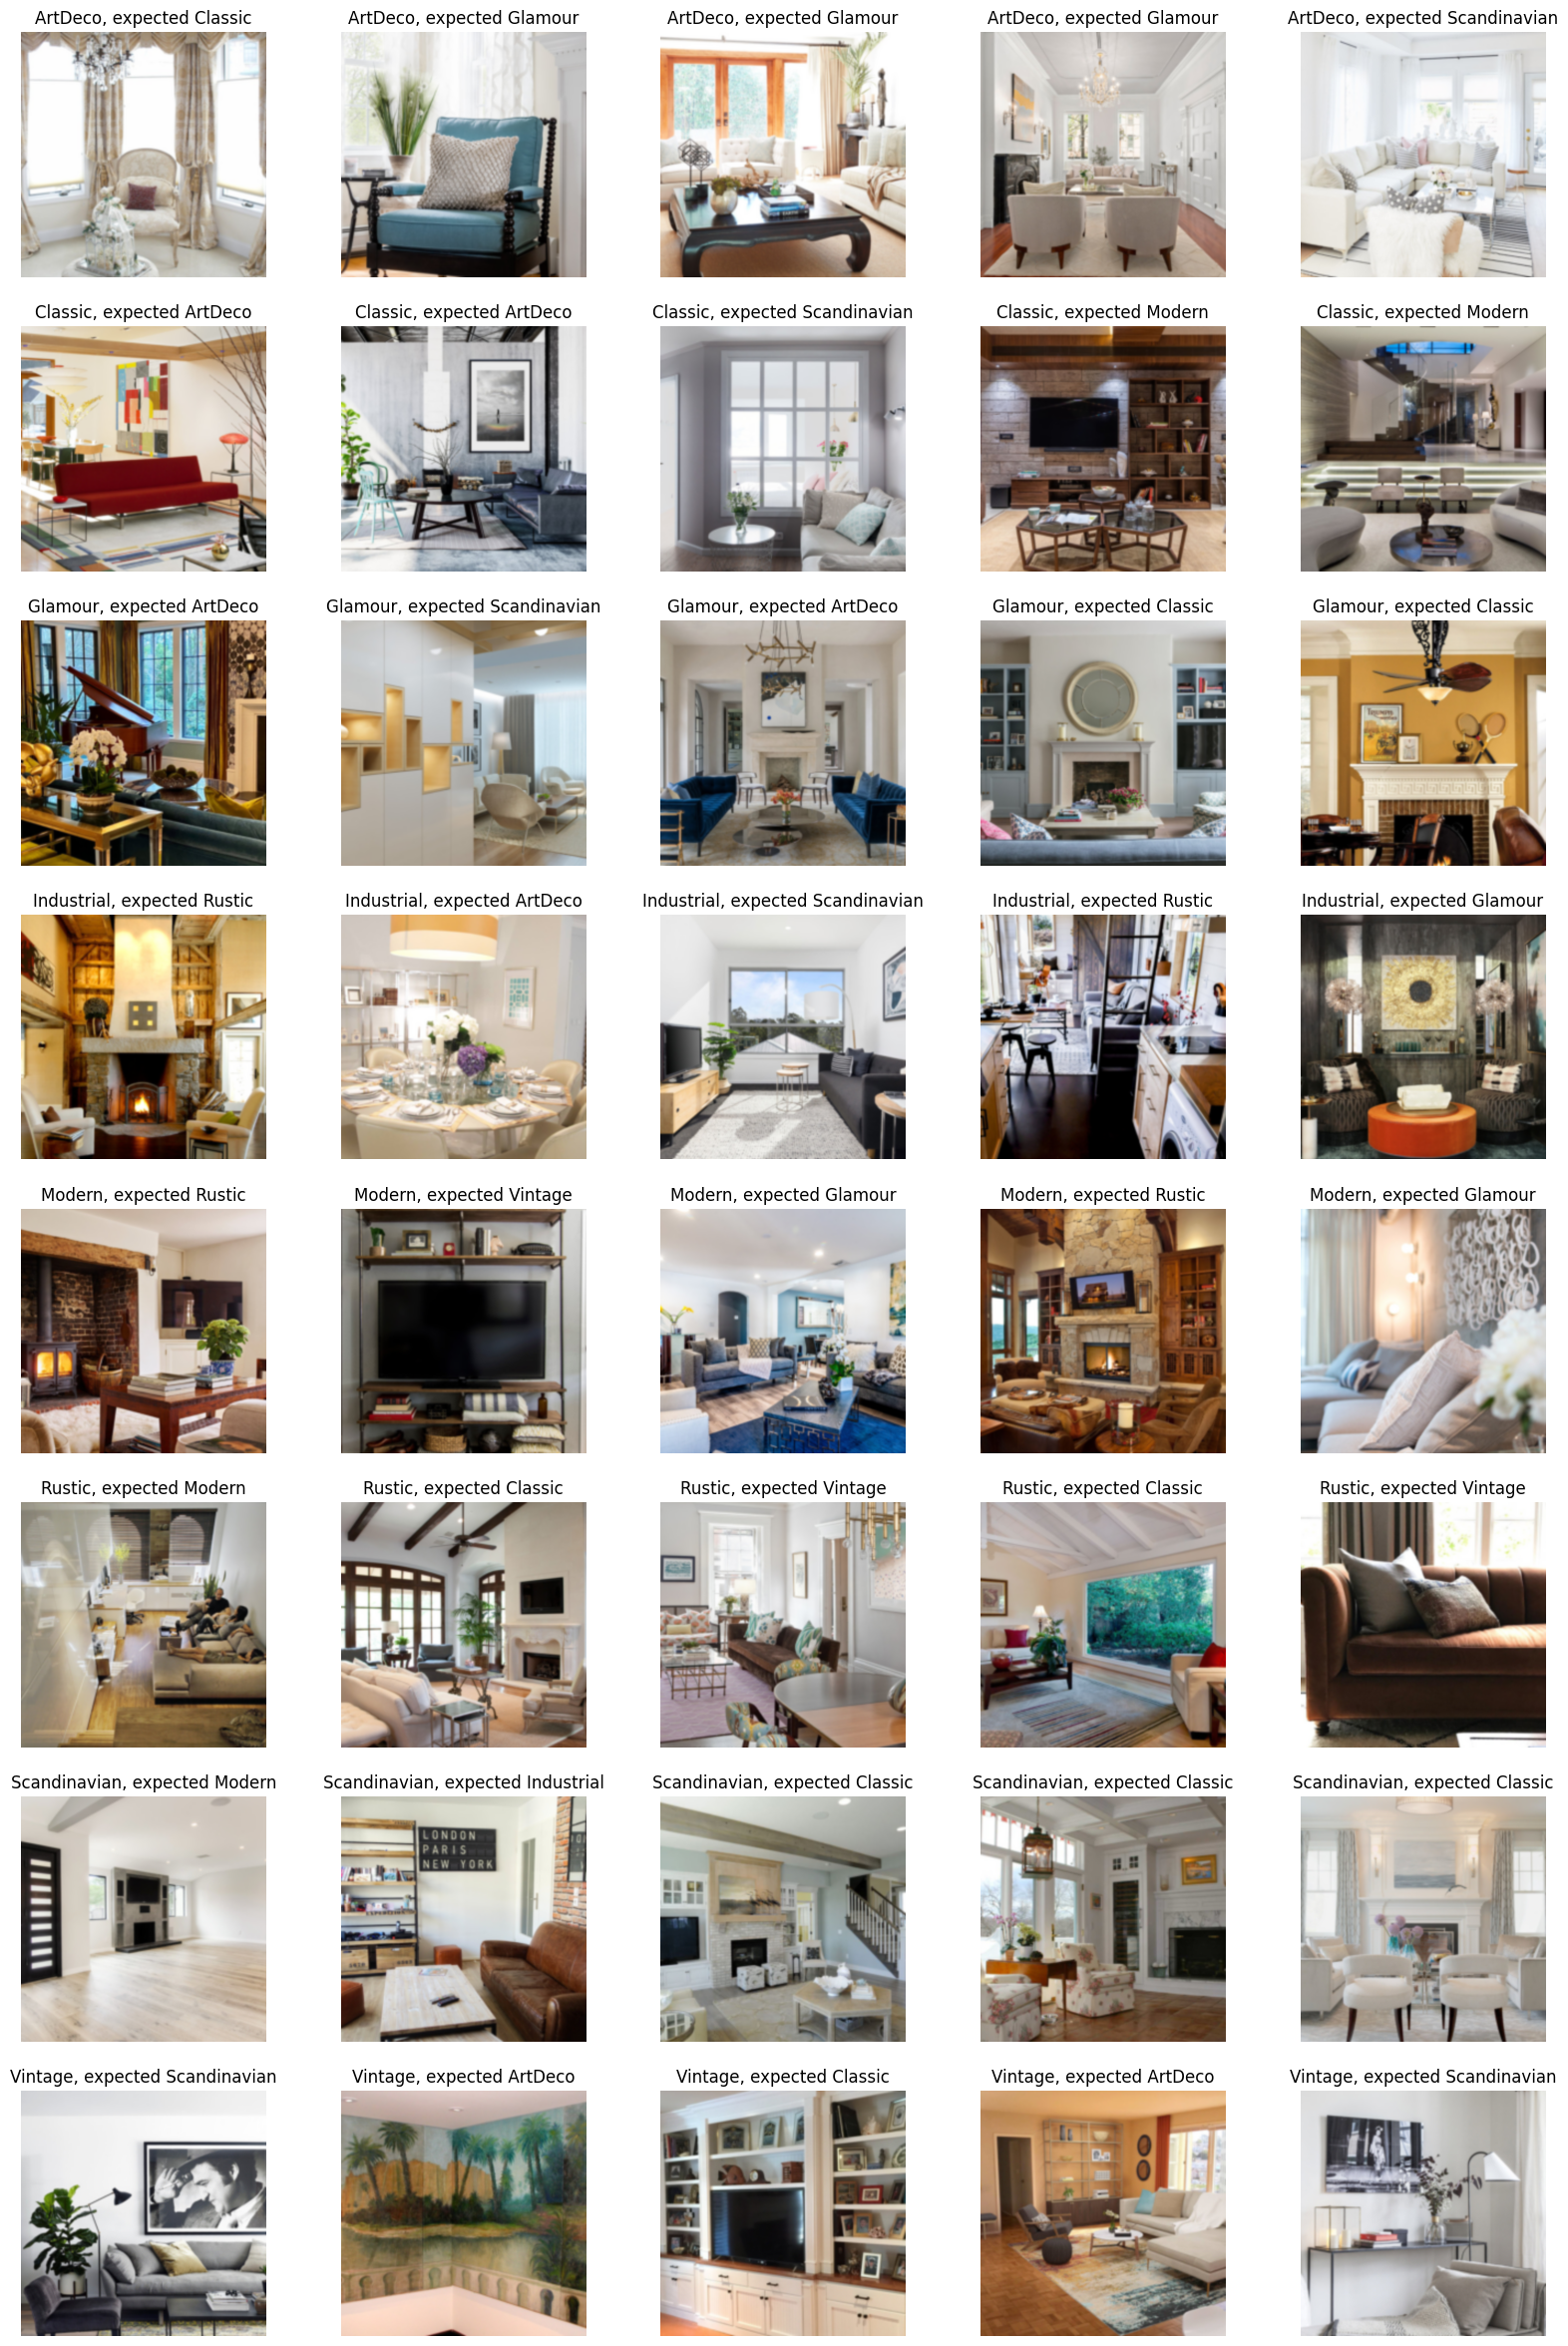

In [13]:
test_metrics, train_metrics = conduct_experiment(
    title=experiment_name,
    model=model,
    n_epochs=epochs,
    optimizer=optimizer,
    flats_dataset_loader=data_loader,
    device=device,)

## Plots

#### Dataset classes distribution, combined plots with training results, missclasified samples

In [14]:
import matplotlib.pyplot as plt
plt.show()

#### Confusion matrix

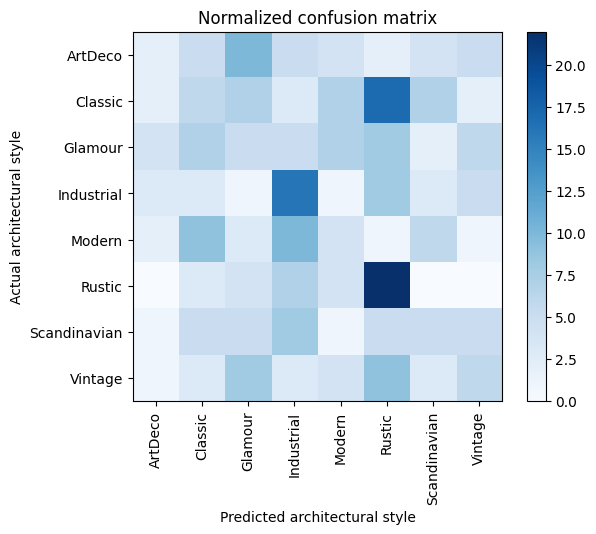

In [15]:
confusion_matrix = plots.plot_confusion_matrix(
    model,
    device,
    data_loader.get_test_loader(),
    classes,
    title="Normalized confusion matrix",
)
plt.show()

## Run predictions on trained model

#### Load model

In [16]:
import matplotlib.pyplot as plt
import os

classes = [
    "ArtDeco",
    "Classic",
    "Glamour",
    "Industrial",
    "Modern",
    "Rustic",
    "Scandinavian",
    "Vintage",
]

# Load the trained model
models_folder_path = os.path.abspath(os.path.join(module_path, "experiments/models"))
trained_model_folder_path = os.path.join(models_folder_path, "VGG16-Jupyter")
trained_model_path = os.path.join(trained_model_folder_path, os.listdir(trained_model_folder_path)[0])
loaded_model = torch.load(trained_model_path)

/Users/adamwojdyla/Documents/Studia/Magisterskie/AITECH_TEMPLATE/AiTechTemplate/.venv/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


#### Load sample image

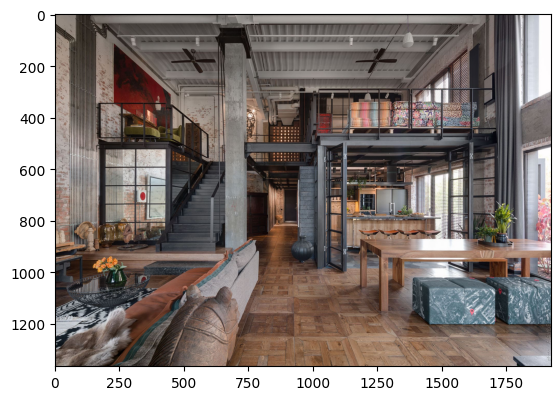

In [17]:
img = plt.imread(os.path.abspath(os.path.join(module_path, "data/images/samples_for_prediction/industrial.jpeg")))
img = np.array(img)
plt.imshow(img)
plt.show()

#### Run predictions on sample

In [18]:
predict_image(loaded_model, classes, 'cpu', img)

Top 3 classification results:
Class: Industrial: Confidence: 23%
Class: Rustic: Confidence: 18%
Class: Modern: Confidence: 12%
{
  "Industrial": 0.23068824410438538,
  "Rustic": 0.18809449672698975,
  "Modern": 0.12671567499637604,
  "Scandinavian": 0.11365719139575958,
  "Classic": 0.11078058928251266,
  "Vintage": 0.09548943489789963,
  "ArtDeco": 0.07340468466281891,
  "Glamour": 0.06116963177919388
}


3